In [1]:
# Author: Matteo Serafino, 2023
#
# This notebook focuses on the analyses presented in Section One of the reference paper.
# 
# Before proceeding, make sure to run "section_one_a_utilities.py" which creates part
# of the necessary files for the analyses. 
#
# The list of files you need to successfully run this notebook is as follows:
#
# 1) "ira_tweets_csv_hashed.csv" which is the IRA datase released by Twitter.
# 2) "news_outlets_2016.csv" wich contains our classificattion of news oulets.
# 3) "users_accounts.txt" contains the classification into account type of all 
#    the users in the 2016 election. his file was obtained by measn of the Twitter
#    user API. See "https://developer.twitter.com/en/docs/twitter-api/users/lookup/api-reference/get-users"
# 4) Datasets:
#     a) "urls_db.sqlite"
#     b) "complete_trump_vs_hillary_db.sqlite"
#     c) "complete_trump_vs_hillary_sep-nov_db.sqlite"
#    These files contain the dataset for the 2016 US election.


In [14]:
# import pandas as pd
import requests
import json
from urllib.parse import urlparse
import numpy as np
from collections import Counter
import pendulum
import sqlite3
import pickle
from scipy.stats import chi2_contingency


from tqdm import tqdm
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc,rcParams

font = {'size'   : 20}
rc('font', **font)
warnings.simplefilter(action='ignore', category=FutureWarning)

def get_hostname(url):
    parsed_url = urlparse(url)
    domain_name = parsed_url.netloc
    return domain_name


gran_path = '/sdf/MatteoPaper/'
raw_data_path = gran_path+'rawdata/'
section1_data_path = gran_path+'section_one/'
figures_data_path = gran_path+'Figures/'

edgelist_data_path = '/home/matteo/IRA_paper/Final_codes_and_data/data/edgelists/categories/edge_lists.pickle'
#edgelist_data_path = '/home/matteo/IRA_paper/Final_codes_and_data/data/edgelists/categories/edge_lists_prova.pickle'

urls_db_file = '/sdf/IRA/urls_db.sqlite'
DB1_NAME = "/disk2/US2016_alex/complete_trump_vs_hillary_db.sqlite"
DB2_NAME = "/disk2/US2016_alex/complete_trump_vs_hillary_sep-nov_db.sqlite"


media_types = ['fake', 'far_right', 'right', 'lean_right', 'center', 'lean_left', 'left',
            'far_left']

start_date = '2016-06-01'
end_date = '2016-11-09'

abbr_to_good={'far_right':'Extreme bias right',
              'fake':'Fake','right':'Right',
              'center':'Center','lean_left':'Left leaning',
              'left':'Left','lean_right':'Right leaning',
              'far_left':'Extreme bias Left'}


official_twitter_clients = ['Twitter for iPhone',
'Twitter for Android',
'Twitter Web Client',
'Twitter for iPad',
'Mobile Web (M5)',
'TweetDeck',
'Facebook',
'Twitter for Windows',
'Mobile Web (M2)',
'Twitter for Windows Phone',
'Mobile Web',
'Google',
'Twitter for BlackBerry',
'Twitter for Android Tablets',
'Twitter for Mac',
'iOS',
'Twitter for BlackBerry®',
'OS X']

news_outlets=json.load(open(raw_data_path+'news_outlets_2016.csv'))
IRAurls=json.load(open(raw_data_path+'Tweets_with_url_IRA.txt'))
users_account=json.load(open(section1_data_path+'users_accounts.txt'))


from palettable.cartocolors.diverging import Geyser_7_r as colormap
mediacolors = colormap.mpl_colors
mediacolors.insert(0, (0.5,0.5,0.5))

def darker(color, percent):
    '''assumes color is rgb between (0, 0, 0) and (1, 1, 1)'''
    color = np.array(color)
    black = np.array([0, 0, 0])
    vector = black-color
    return color + vector * percent

colors={}
mediacolors_bb = mediacolors[:]
mediacolors_bb.insert(1, mediacolors[1])
mediacolors_bb.insert(-1, mediacolors[-1])
index=['Fake','Extreme bias right','Right','Right leaning','Center','Left leaning','Left','Extreme bias Left']
for name, color in zip(index,
        mediacolors_bb):
    colors[name] = list(darker(color,0.2)) + [1.0]

In [15]:
print(pd.DataFrame(official_twitter_clients,columns=['Official clients']).to_latex())

\begin{tabular}{ll}
\toprule
{} &             Official clients \\
\midrule
0  &           Twitter for iPhone \\
1  &          Twitter for Android \\
2  &           Twitter Web Client \\
3  &             Twitter for iPad \\
4  &              Mobile Web (M5) \\
5  &                    TweetDeck \\
6  &                     Facebook \\
7  &          Twitter for Windows \\
8  &              Mobile Web (M2) \\
9  &    Twitter for Windows Phone \\
10 &                   Mobile Web \\
11 &                       Google \\
12 &       Twitter for BlackBerry \\
13 &  Twitter for Android Tablets \\
14 &              Twitter for Mac \\
15 &                          iOS \\
16 &      Twitter for BlackBerry® \\
17 &                         OS X \\
\bottomrule
\end{tabular}



# IRA Dataset

In [26]:
all_ira=pd.read_csv(raw_data_path+'ira_tweets_csv_hashed.csv')

/tmp/ipykernel_20359/416655172.py:1: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  all_ira=pd.read_csv(raw_data_path+'ira_tweets_csv_hashed.csv')


In [27]:
#Overall Ira activity
print('N° unique users: ', len(pd.unique(all_ira['userid'])))
print('N° unique tweets: ', len(all_ira))
print('Min date account creation: ', min(all_ira['account_creation_date']))
print('Max date account creation: ', max(all_ira['account_creation_date']))
print('N° tweets in ru: ', len(all_ira[all_ira['tweet_language']=='ru'])/len(all_ira))
print('N° tweets in en: ', len(all_ira[all_ira['tweet_language']=='en'])/len(all_ira))

N° unique users:  3667
N° unique tweets:  9041308
Min date account creation:  2009-04-24
Max date account creation:  2018-04-03
N° tweets in ru:  0.5367790810798615
N° tweets in en:  0.36078087374083484


In [28]:
#Focus between start and end date. Only Tweets in English
all_ira_e=all_ira[all_ira['tweet_language']=='en']
print('Tweets in English: ',len(all_ira_e))

all_ira_e=all_ira_e[(all_ira_e['tweet_time']>start_date) & (all_ira_e['tweet_time']<end_date)]

print('Tweets in English between June and November 8, 2016: ', len(all_ira_e))
print('Accounts in English between June and November 8, 2016: ', len(pd.unique(all_ira_e['userid'])))

Tweets in English:  3261931
Tweets in English between June and November 8, 2016:  391680
Accounts in English between June and November 8, 2016:  556


In [29]:
len(IRAurls)

126331

In [30]:
#Here we check how many tweets points to a website. I focus here on the tweet activity
categories=Counter()
for tweeiid in IRAurls:
    hostname=IRAurls[tweeiid]['hostname']
    if hostname in news_outlets:
        categories[news_outlets[hostname]]+=1

In [31]:
sum(list(categories.values()))

23806

In [32]:
pd.DataFrame(dict(categories), index=[0]).rename(columns=abbr_to_good).to_csv(section1_data_path+'IRA_count_per_category.csv',
            index=False)

In [33]:
#Here we check how many tweets points to a website. I focus here in the user activity
users={}
id_to_consider=[]
hostnames = {}

for tweeiid in IRAurls:
    hostname=IRAurls[tweeiid]['hostname']
    if hostname in news_outlets:
        
        id_to_consider.append(tweeiid)
        hostnames[tweeiid] = news_outlets[hostname]
        
        if list(all_ira[all_ira.tweetid==int(tweeiid)]['userid'])[0] not in users:
            users[list(all_ira[all_ira.tweetid==int(tweeiid)]['userid'])[0]]=Counter()
        users[list(all_ira[all_ira.tweetid==int(tweeiid)]['userid'])[0]][news_outlets[hostname]]+=1

In [34]:
users_per_cat = Counter()
for line in users:
    users_per_cat[users[line].most_common(1)[0][0]]+=1

In [35]:
sum(users_per_cat.values())

334

In [36]:
pd.DataFrame(dict(users_per_cat), index=[0]) \
            .rename(columns=abbr_to_good) \
            .to_csv(section1_data_path+'IRA_users_per_category.csv',index=False)

In [37]:
#Here I compute the file i will need fot the sources plot
IRA_sources=all_ira[all_ira.tweetid.isin([int(i) for i in id_to_consider])][['tweetid','tweet_client_name']]

cls,hstnms=[],[]
for _,lin in IRA_sources.iterrows():
    tid = str(lin['tweetid'])
    if lin['tweet_client_name'] in official_twitter_clients:
         cls.append('Official')
    else:
        cls.append('Not Official')
    hstnms.append(hostnames[tid])
    
IRA_sources['category'] = hstnms
IRA_sources['tweet_client_name_class'] = cls

IRA_sources_no = IRA_sources[IRA_sources['tweet_client_name_class']!='Official']

IRA_sources = IRA_sources.groupby(['category','tweet_client_name_class'], as_index=False).count()

IRA_sources.to_csv(section1_data_path+'IRA_sources.csv')

In [38]:
IRA_sources_no.groupby(['tweet_client_name']).count().sort_values('tweetid', ascending=False).head(2)

,tweetid,category,tweet_client_name_class
tweet_client_name,,,
twitterfeed,4102,4102,4102
Twibble.io,953,953,953


In [39]:
#IRA tweet activity overt time
#Here we check the IRA activity over time
IRA_activity={}
for language in ['ru','en','all_languages']:
    IRA_activity[language]=Counter()
    if language =='all_languages':
        temporary=all_ira
    else:
        temporary=all_ira[all_ira['tweet_language']==language]
    for dt in temporary['tweet_time'].to_list():
        IRA_activity[language][pendulum.parse(dt).to_date_string()]+=1
        
    to_save=pd.DataFrame(IRA_activity[language],index=[0]).transpose()
    to_save['day']=to_save.index
    to_save=to_save.rename(columns = {0:'count'})
    to_save.to_csv(section1_data_path+f'IRAactivity_{language}.to_csv',index=False)

In [40]:
en_tw=pd.read_csv(section1_data_path+'IRAactivity_en.to_csv').sort_values(by='day')
en_tw['dt']=[pendulum.parse(dt).to_date_string()[:-3] for dt in en_tw['day']]
en_tw=en_tw.groupby('dt',as_index=False).sum()

rs_tw=pd.read_csv(section1_data_path+'IRAactivity_ru.to_csv').sort_values(by='day')
rs_tw['dt']=[pendulum.parse(dt).to_date_string()[:-3] for dt in rs_tw['day']]
rs_tw=rs_tw.groupby('dt',as_index=False).sum()

all_tw=pd.read_csv(section1_data_path+'IRAactivity_all_languages.to_csv').sort_values(by='day')
all_tw['dt']=[pendulum.parse(dt).to_date_string()[:-3] for dt in all_tw['day']]
all_tw=all_tw.groupby('dt',as_index=False).sum()

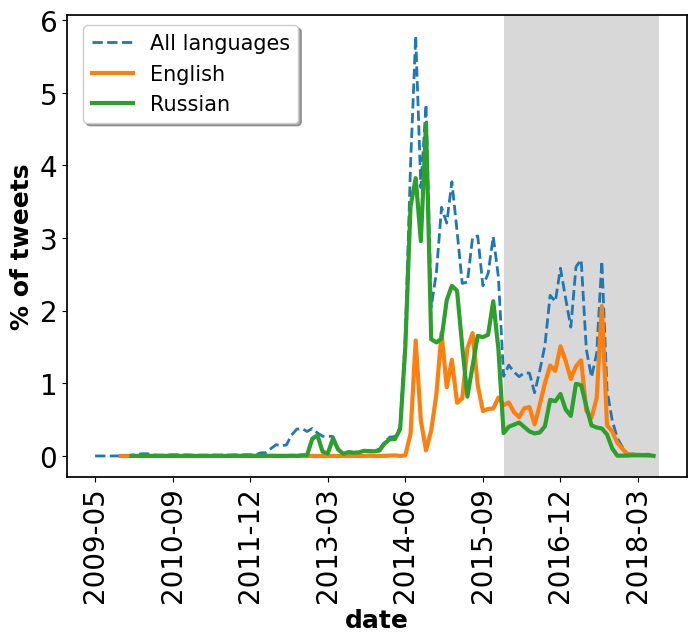

In [41]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.25)

plt.plot(all_tw['dt'],all_tw['count']/sum(all_tw['count'])*100,'--',linewidth=2,label='All languages')
plt.plot(en_tw['dt'],en_tw['count']/sum(all_tw['count'])*100,'-',linewidth=3,label='English')
plt.plot(rs_tw['dt'],rs_tw['count']/sum(all_tw['count'])*100,'-',linewidth=3,label='Russian')


plt.ylabel('% of tweets',fontsize=18,fontweight='bold')
plt.xlabel('date',fontsize=18,fontweight='bold')
plt.axvspan('2016-01', '2018-12', color='gray', alpha=0.3, lw=0)
plt.xticks(ax.xaxis.set_major_locator(plt.MaxNLocator(8)),rotation=90)

plt.legend(loc='upper center',bbox_to_anchor=(0.2, 1.0), shadow=True, ncol=1, prop={'size': 15})

#ax.tick_params( length=5, width=1, grid_alpha=0.2)

plt.savefig('Figures/'+'Fig1b.pdf',bbox_inches='tight')
plt.show()

In [42]:
#IRA account creation oer time
temporary=all_ira[['userid','account_creation_date']].drop_duplicates()
temporary['dt']=[pendulum.parse(dt).to_date_string()[:-3] for dt in temporary['account_creation_date']]

#
y=np.array(temporary.groupby('dt').count()['userid'].tolist())
x=temporary.groupby('dt').count().index

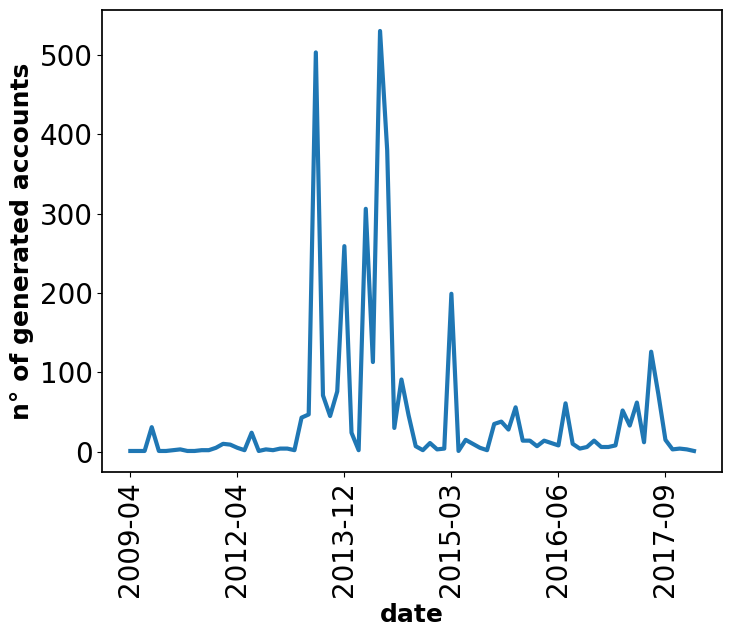

In [43]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.25)

plt.plot(x,y,'-',linewidth=3)


plt.ylabel('n° of generated accounts',fontsize=18,fontweight='bold')
plt.xlabel('date',fontsize=18,fontweight='bold')

plt.xticks(ax.xaxis.set_major_locator(plt.MaxNLocator(6)),rotation=90)

#plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.12), shadow=True, ncol=2, prop={'size': 15})

#ax.tick_params( length=5, width=1, grid_alpha=0.2)

plt.savefig('Figures/'+'Fig1a.pdf',bbox_inches='tight')

plt.show()

# 2016 Dataset

In [44]:
#upload the data per category
gran_path = '/sdf/MatteoPaper/'
section1_data_path = gran_path+'section_one/'
c=0
categories={}
for media_type in ['fake', 'far_right', 'right', 'lean_right', 'center', 'lean_left', 'left','far_left']:
    
    data = pd.read_pickle(section1_data_path+f'{media_type}.pkl')
    data = data[(data.datetime_EST>=start_date) & (data.datetime_EST<=end_date)]
    categories[media_type] = data

In [45]:
tweets_count = 0 
users_counts  = set()
for media_type in categories:
    tweets_count += len(categories[media_type]['tweet_id'].to_list())
    users_counts = users_counts.union(set(categories[media_type]['user_id'].to_list()))
    
print('Total tweets pointing to a news outlet ', tweets_count)
print('Total users pointing to a news outlet ', len(users_counts))

Total tweets pointing to a news outlet  30829133
Total users pointing to a news outlet  2267781


In [46]:
tweets_per_category = {}
source_per_category = {}

missing = 0 
for media_type in media_types:
    temp = categories[media_type]
    types = []
    sources = []
    for user,source in zip(temp['user_id'].astype(str).to_list(),temp['source_content'].astype(str).to_list()):
        if user in users_account:
            types.append(users_account[user])
        else:
            missing+=1
            types.append(None)
        if source in official_twitter_clients:
            sources.append('Official')
        else:
            sources.append('Not Official')
            
    temp['account_type'] = types
    temp['source_content_official'] = sources
    
    sources_ = temp.groupby(['source_content_official','account_type'],as_index=False)\
    .count()[['account_type','source_content_official','tweet_id']]\
    .rename(columns={'tweet_id':'count'})

    sources_.reset_index(drop=True, inplace=True)
    #sources_['media_type'] = [ media_type for i in range(len(sources_))]
    
    temp =temp.groupby('account_type',as_index=False)\
                             .count()[['account_type','tweet_id']]\
                             .rename(columns={'tweet_id':'count'})
    
    tweets_per_category[media_type] = temp.set_index('account_type').T.to_dict('records')[0]
    
    source_per_category[media_type] = sources_
    
source_per_category = pd.concat(source_per_category)
source_per_category.to_csv(section1_data_path+'All_sources_per_category.csv')

In [47]:
concatenated_df = pd.concat(categories, ignore_index=True)
concatenated_df = concatenated_df[concatenated_df['source_content_official']!='Official']
concatenated_df.groupby(['account_type','source_content']).count().sort_values('tweet_id', ascending=False).groupby('account_type',as_index=False).head(2)

tweet_id  user_id  datetime_EST  \
account_type source_content                                    
Not verified twitterfeed       605403   605403        605403   
Suspended    dlvr.it           521450   521450        521450   
Not verified dlvr.it           379960   379960        379960   
Suspended    IFTTT             368670   368670        368670   
Verified     SocialFlow        171116   171116        171116   
Not found    IFTTT              53342    53342         53342   
             twitterfeed        44910    44910         44910   
Verified     Hootsuite          31604    31604         31604   

                             source_content_official  
account_type source_content                           
Not verified twitterfeed                      605403  
Suspended    dlvr.it                          521450  
Not verified dlvr.it                          379960  
Suspended    IFTTT                            368670  
Verified     SocialFlow                       171116  
Not found    IFTTT                             53342  
             twitterfeed                       44910  
Verified     Hootsuite                         31604

In [48]:
#save data
infos = []
columns = []
for key in tweets_per_category:
    infos.append([tweets_per_category[key][i] for i in ['Not verified', 'Suspended', 'Not found', 'Verified'] ])
    columns.append(abbr_to_good[key])
    
df=pd.DataFrame(infos,columns=['Not Verified', 'Suspended', 'Not Found', 'Verified'],\
                index=columns)
df=df.transpose()
df.to_csv(section1_data_path+'All_counts_per_category.csv',index=True)

In [49]:
#users per category
users_per_category={}
missing = 0 
for media_type in media_types:
    temp = categories[media_type]
    types=[]
    for user in temp['user_id'].astype(str).to_list():
        if user in users_account:
            types.append(users_account[user])
        else:
            missing+=1
            types.append(None)
    temp['account_type'] = types

    temp = temp[['user_id','account_type']].drop_duplicates() \
                                    .groupby('account_type',as_index=False)\
                                    .count()\
                                    .rename(columns={'user_id':'count'})
    users_per_category[media_type]=temp.set_index('account_type').T.to_dict('records')[0]

In [50]:
#save data
infos = []
columns = []
for key in users_per_category:
    infos.append([users_per_category[key][i] for i in ['Not verified', 'Suspended', 'Not found', 'Verified'] ])
    columns.append(abbr_to_good[key])
    
df=pd.DataFrame(infos,columns=['Not Verified', 'Suspended', 'Not Found', 'Verified'],\
                index=columns)
df=df.transpose()
df.to_csv(section1_data_path+'All_users_per_category.csv',index=True)

In [51]:
#Here we compute the n° of tweets from the 2016 election pointing to a news outlet 
newsoutlets={}
for media_type in media_types:
    newsoutlets[media_type]=[]
    with sqlite3.connect(urls_db_file, 
                             detect_types=sqlite3.PARSE_DECLTYPES|sqlite3.PARSE_COLNAMES) as conn:

        c = conn.cursor()
        c.execute(f'''SELECT * FROM hosts_{media_type}_rev_stat WHERE perccum > 0.01;''')
        d=c.fetchall()
        for line in d:
            newsoutlets[media_type].append((line[1],int(line[3])))
        c.close()
        
with open(section1_data_path+'count_per_outlet.txt','w') as file:
    file.write(json.dumps(newsoutlets)+'\n')

# Plot bars for section 1

In [52]:
#Activity

In [53]:
all_activity=pd.read_csv(section1_data_path+'All_counts_per_category.csv',index_col=['Unnamed: 0'])
IRA_tweets_activity=pd.read_csv(section1_data_path+'IRA_count_per_category.csv')

In [54]:
infos_IRA=[]
for category in all_activity.columns:
    infos_IRA.append(list(IRA_tweets_activity[category])[0])

In [55]:
infos_IRA = pd.DataFrame(infos_IRA,columns=['IRA'],index=all_activity.columns).transpose()

In [56]:
all_activity=all_activity.append(infos_IRA)

In [57]:
all_activity=all_activity.div(all_activity.sum(axis=1), axis=0)*100


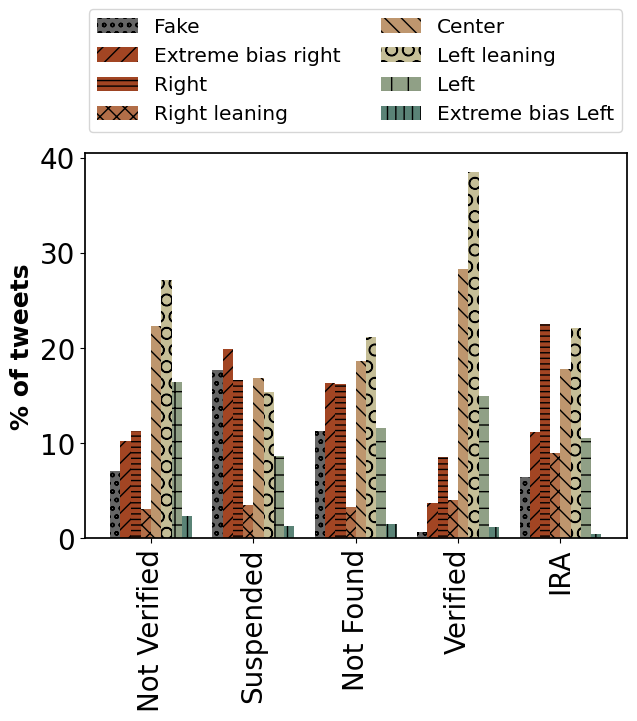

In [58]:
ax = all_activity.plot(kind='bar',figsize=(7,5), width=0.8,legend=False,color=[colors[group] for group in all_activity.columns])


for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.25)

bars = ax.patches
hatches=[]
for i in ["oo","//","---","xx","\\\\","O","+","||"]:
    for _ in range(5):
        hatches.append(i)

for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

plt.ylabel('% of tweets',fontsize=18,fontweight='bold')

plt.xticks(rotation=90)

plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.4), ncol=2, prop={'size': 14.5})

plt.savefig('Figures/'+'Fig2a.pdf',bbox_inches='tight')

plt.show()


In [59]:
#users

In [60]:
IRA_user_activity=pd.read_csv(section1_data_path+'IRA_users_per_category.csv')
all_users=pd.read_csv(section1_data_path+'All_users_per_category.csv',index_col=['Unnamed: 0'])

In [61]:
infos_IRA=[]
for category in all_users.columns:
    if category in IRA_user_activity:
        infos_IRA.append(list(IRA_user_activity[category])[0])
    else:
        infos_IRA.append(0)

In [62]:
infos_IRA = pd.DataFrame(infos_IRA,columns=['IRA'],index= all_users.columns).transpose()
all_users=all_users.append(infos_IRA)
all_users=all_users.div(all_users.sum(axis=1), axis=0)*100
all_users=all_users[all_activity.columns]

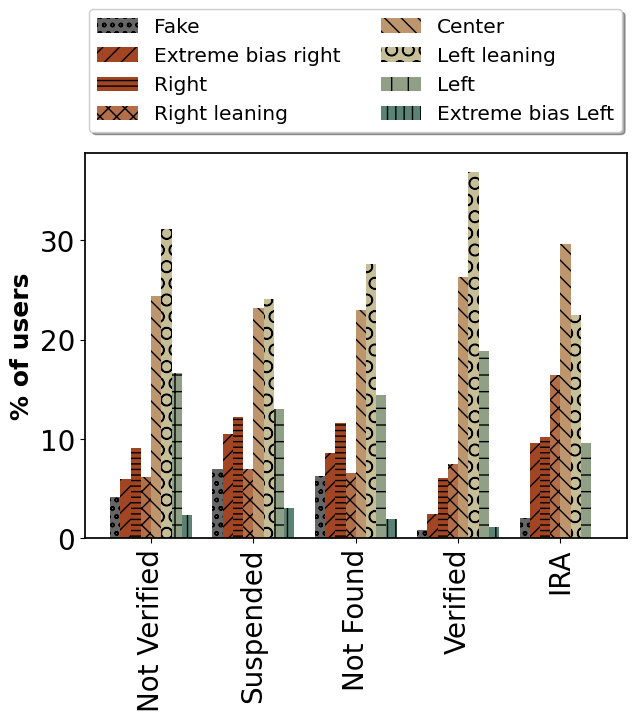

In [63]:
ax = all_users.plot(kind='bar',figsize=(7,5), width=0.8,legend=False,color=[colors[group] for group in all_users.columns])


for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.25)

bars = ax.patches
hatches=[]
for i in ["oo","//","---","xx","\\\\","O","+","||"]:
    for _ in range(5):
        hatches.append(i)

for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

plt.ylabel('% of users',fontsize=18,fontweight='bold')

plt.xticks(rotation=90)

plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.4), shadow=True, ncol=2, prop={'size': 14.5})


plt.savefig('Figures/'+'Fig2b.pdf',bbox_inches='tight')

plt.show()

# Sources

In [64]:
#Set s to 0 for non Offical source, to 1 otherwise.
s=1

In [65]:
if s == 0:
    source_type = 'Not Official'
    fig = 'Fig3a.pdf'
else:
    source_type = 'Official'
    fig = 'Fig3b.pdf'
#upload IRA data
IRA_sources=pd.read_csv(section1_data_path+'IRA_sources.csv')
tot = sum(list(IRA_sources['tweetid']))

transformIRA = []
temps = []
for line in abbr_to_good.keys():
    try: 
        temp_ = IRA_sources[(IRA_sources['category']==line) & (IRA_sources['tweet_client_name_class']==source_type)]
        temps.append(list(temp_['tweetid'])[0]/tot)
    except:
        print(line)
        temps.append(0)

transformIRA.append(temps)


df_IRA = pd.DataFrame(transformIRA,columns=abbr_to_good.values(),index=['IRA'])
#upload All data
all_source = pd.read_csv(section1_data_path+'All_sources_per_category.csv',index_col=False)
del all_source['Unnamed: 1']
tot = all_source.groupby('account_type',as_index=False).sum()[['account_type','count']]\
                .set_index('account_type').T.to_dict('records')[0]

transform = []
for elm in pd.unique(all_source['account_type']):
    temps = []
    temp = all_source[all_source.account_type==elm]
    for line in abbr_to_good.keys():
        temp_ = temp[(temp['Unnamed: 0']==line) & (temp['source_content_official']==source_type)]
        temps.append(round(list(temp_['count'])[0]/tot[elm],3))

    transform.append(temps)
df = pd.DataFrame(transform,columns=abbr_to_good.values(),index=pd.unique(all_source['account_type']))

df = df.append(df_IRA)
df = df[['Fake', 'Extreme bias right', 'Right', 'Right leaning', 'Center',
       'Left leaning', 'Left', 'Extreme bias Left']]*100

df = df.round(2)

df = df.rename(index={'Not found': 'Not Found',
                      'Not verified': 'Not Verified'})

df = df.reindex([ 'Not Verified', 'Suspended','Not Found','Verified', 'IRA'])

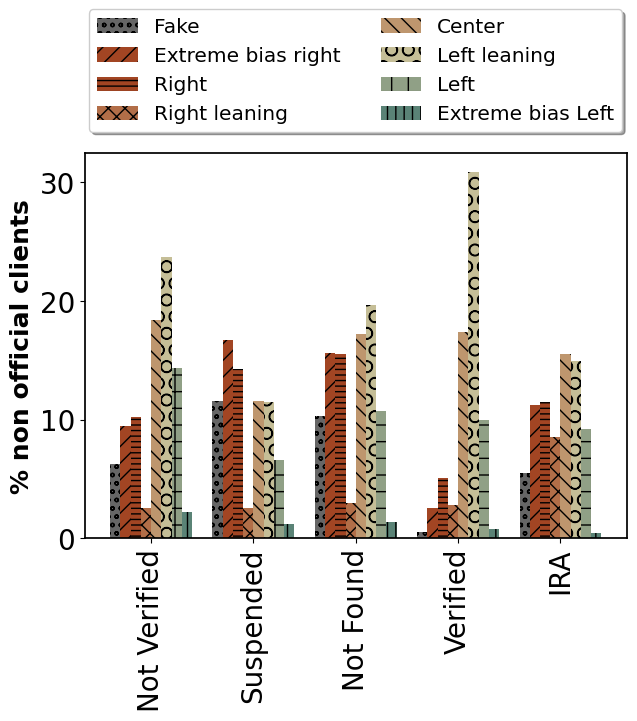

In [66]:
ax = df.plot(kind='bar',figsize=(7,5), width=0.8,legend=False,color=[colors[group] for group in df.columns])



for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.25)

bars = ax.patches
hatches=[]
for i in ["oo","//","---","xx","\\\\","O","+","||"]:
    for _ in range(5):
        hatches.append(i)

for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

plt.ylabel('% non official clients',fontsize=18,fontweight='bold')

plt.xticks(rotation=90)

plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.4), shadow=True, ncol=2, prop={'size': 14.5})

plt.savefig('Figures/'+fig,bbox_inches='tight')

plt.show()

In [67]:
df.sum(axis=1)

Not Verified    87.30
Suspended       76.10
Not Found       93.40
Verified        70.10
IRA             77.06
dtype: float64

# Chi contingency

In [68]:
all_activity=pd.read_csv(section1_data_path+'All_counts_per_category.csv',index_col=['Unnamed: 0'])
IRA_tweets_activity=pd.read_csv(section1_data_path+'IRA_count_per_category.csv')
infos_IRA=[]
for category in all_activity.columns:
    infos_IRA.append(list(IRA_tweets_activity[category])[0])
infos_IRA = pd.DataFrame(infos_IRA,columns=['IRA'],index=all_activity.columns).transpose()
all_activity=all_activity.append(infos_IRA)
#all_activity=all_activity.div(all_activity.sum(axis=1), axis=0)

In [69]:
# interpret p-value
alpha = 0.001
p_values_matrix=np.zeros((5,5))
for row,idx in enumerate(all_activity.index):
    for col,idx2 in enumerate(all_activity.index):
        data=np.array([all_activity.loc[idx].to_list(),all_activity.loc[idx2].to_list()])
        stat, p, dof, expected = chi2_contingency(data) 
        if p <= alpha:
            p_values_matrix[row,col]=1
        else:
            p_values_matrix[row,col]=0

In [70]:
p_values_matrix

array([[0., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1.],
       [1., 1., 0., 1., 1.],
       [1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 0.]])

In [71]:
IRA_user_activity=pd.read_csv(section1_data_path+'IRA_users_per_category.csv')
all_users=pd.read_csv(section1_data_path+'All_users_per_category.csv',index_col=['Unnamed: 0'])
infos_IRA=[]
for category in all_users.columns:
    if category in IRA_user_activity:
        infos_IRA.append(list(IRA_user_activity[category])[0])
    else:
        infos_IRA.append(0)
infos_IRA = pd.DataFrame(infos_IRA,columns=['IRA'],index=all_users.columns).transpose()
all_users=all_users.append(infos_IRA)
all_users=all_users[all_activity.columns]

In [72]:
all_users.loc['IRA']['Extreme bias Left']=1
# interpret p-value
alpha = 0.001
p_values_matrix=np.zeros((5,5))
for row,idx in enumerate(all_users.index):
    for col,idx2 in enumerate(all_users.index):
        
        data=np.array([all_users.loc[idx].to_list(),all_users.loc[idx2].to_list()])
        stat, p, dof, expected = chi2_contingency(data) 
        if p <= alpha:
            p_values_matrix[row,col]=1
        else:
            p_values_matrix[row,col]=0

In [73]:
p_values_matrix

array([[0., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1.],
       [1., 1., 0., 1., 1.],
       [1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 0.]])

In [74]:
#contingency for sources type
s=1

In [85]:
if s == 0:
    source_type = 'Not Official'
else:
    source_type = 'Official'
#upload IRA data
IRA_sources=pd.read_csv(section1_data_path+'IRA_sources.csv')

transformIRA = []
temps = []
for line in abbr_to_good.keys():
    try: 
        temp_ = IRA_sources[(IRA_sources['category']==line) & (IRA_sources['tweet_client_name_class']==source_type)]
        temps.append(list(temp_['tweetid'])[0])
    except:
        print(line)
        temps.append(0)

transformIRA.append(temps)


df_IRA = pd.DataFrame(transformIRA,columns=abbr_to_good.values(),index=['IRA'])
#upload All data
all_source = pd.read_csv(section1_data_path+'All_sources_per_category.csv',index_col=False)
del all_source['Unnamed: 1']
tot = all_source.groupby('account_type',as_index=False).sum()[['account_type','count']]\
                .set_index('account_type').T.to_dict('records')[0]

transform = []
for elm in pd.unique(all_source['account_type']):
    temps = []
    temp = all_source[all_source.account_type==elm]
    for line in abbr_to_good.keys():
        temp_ = temp[(temp['Unnamed: 0']==line) & (temp['source_content_official']==source_type)]
        temps.append(list(temp_['count'])[0])

    transform.append(temps)
df = pd.DataFrame(transform,columns=abbr_to_good.values(),index=pd.unique(all_source['account_type']))

df = df.append(df_IRA)
df = df[['Fake', 'Extreme bias right', 'Right', 'Right leaning', 'Center',
       'Left leaning', 'Left', 'Extreme bias Left']]

df = df.round(2)

df = df.rename(index={'Not found': 'Not Found',
                      'Not verified': 'Not Verified'})

df = df.reindex([ 'Not Verified', 'Suspended','Not Found','Verified', 'IRA'])

if s == 0:
    df.loc['IRA']['Extreme bias Left'] = 1
    df.loc['IRA']['Extreme bias right'] = 1

In [86]:
alpha = 0.001
p_values_matrix=np.zeros((5,5))
for row,idx in enumerate(df.index):
    for col,idx2 in enumerate(df.index):
        data=np.array([df.loc[idx].to_list(),df.loc[idx2].to_list()])
        stat, p, dof, expected = chi2_contingency(data) 
        if p <= alpha:
            p_values_matrix[row,col]=1
        else:
            p_values_matrix[row,col]=0

In [87]:
p_values_matrix

array([[0., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1.],
       [1., 1., 0., 1., 1.],
       [1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 0.]])

# Supplementary tables 2, 3 and 4  

In [88]:
lines_=[]
for _,line in all_activity.div(all_activity.sum(axis=1), axis=0).iterrows():
    line_=[]
    for key in line.keys():
        line_.append(f'{all_activity.loc[_][key]} ({str(round(line[key]*100,2))})')
    lines_.append(line_)

In [89]:
to_si=pd.DataFrame(lines_,columns=line.keys(),index=all_activity.index)

In [90]:
to_si.index

Index(['Not Verified', 'Suspended', 'Not Found', 'Verified', 'IRA'], dtype='object')

In [91]:
print(to_si.to_latex())

\begin{tabular}{lllllllll}
\toprule
{} &             Fake & Extreme bias right &            Right &  Right leaning &           Center &     Left leaning &             Left & Extreme bias Left \\
\midrule
Not Verified &   1345382 (7.11) &     1930006 (10.2) &  2143836 (11.33) &  583731 (3.09) &  4228470 (22.35) &  5133680 (27.13) &  3110895 (16.44) &     443785 (2.35) \\
Suspended    &  1114096 (17.73) &    1248410 (19.87) &  1044299 (16.62) &  221598 (3.53) &  1061140 (16.89) &   966436 (15.38) &    544449 (8.66) &      83650 (1.33) \\
Not Found    &   516945 (11.24) &     752874 (16.37) &   747178 (16.24) &  150946 (3.28) &   858291 (18.66) &   973901 (21.17) &   531486 (11.55) &      68656 (1.49) \\
Verified     &      6571 (0.64) &       38552 (3.76) &     87886 (8.58) &   41824 (4.08) &   289405 (28.24) &   394608 (38.51) &   153316 (14.96) &      12484 (1.22) \\
IRA          &      1541 (6.47) &       2670 (11.22) &      5356 (22.5) &    2124 (8.92) &      4238 (17.8) &     5251 (

In [92]:
lines_=[]
for _,line in all_users.div(all_users.sum(axis=1), axis=0).iterrows():
    line_=[]
    for key in line.keys():
        line_.append(f'{all_users.loc[_][key]} ({str(round(line[key]*100,2))})')
    lines_.append(line_)

In [93]:
to_si=pd.DataFrame(lines_,columns=line.keys(),index=all_users.index)

In [94]:
to_si

,Fake,Extreme bias right,Right,Right leaning,Center,Left leaning,Left,Extreme bias Left
Not Verified,120519 (4.21),172370 (6.02),259133 (9.05),176962 (6.18),698260 (24.39),891985 (31.16),475368 (16.61),67764 (2.37)
Suspended,38624 (6.97),58436 (10.54),67455 (12.17),38660 (6.98),128270 (23.14),133549 (24.1),72270 (13.04),16976 (3.06)
Not Found,43901 (6.27),60188 (8.6),80900 (11.56),46048 (6.58),160640 (22.96),193421 (27.64),100999 (14.43),13661 (1.95)
Verified,781 (0.84),2308 (2.5),5588 (6.04),6907 (7.47),24280 (26.26),34111 (36.89),17456 (18.88),1046 (1.13)
IRA,7 (2.09),32 (9.55),34 (10.15),55 (16.42),99 (29.55),75 (22.39),32 (9.55),1 (0.3)


In [95]:
print(to_si.to_latex())

\begin{tabular}{lllllllll}
\toprule
{} &           Fake & Extreme bias right &          Right &  Right leaning &          Center &    Left leaning &            Left & Extreme bias Left \\
\midrule
Not Verified &  120519 (4.21) &      172370 (6.02) &  259133 (9.05) &  176962 (6.18) &  698260 (24.39) &  891985 (31.16) &  475368 (16.61) &      67764 (2.37) \\
Suspended    &   38624 (6.97) &      58436 (10.54) &  67455 (12.17) &   38660 (6.98) &  128270 (23.14) &   133549 (24.1) &   72270 (13.04) &      16976 (3.06) \\
Not Found    &   43901 (6.27) &        60188 (8.6) &  80900 (11.56) &   46048 (6.58) &  160640 (22.96) &  193421 (27.64) &  100999 (14.43) &      13661 (1.95) \\
Verified     &     781 (0.84) &         2308 (2.5) &    5588 (6.04) &    6907 (7.47) &   24280 (26.26) &   34111 (36.89) &   17456 (18.88) &       1046 (1.13) \\
IRA          &       7 (2.09) &          32 (9.55) &     34 (10.15) &     55 (16.42) &      99 (29.55) &      75 (22.39) &       32 (9.55) &           1 (0